# R.O.P: Railway Oriented Programming in Swift

This cool approach proposed by Scott Wlaschin is essentially a revisited version of classic "either monad". 
I've little bit renamed types and basic methods to be much more "intuitive" and "spoken-english-like".

More on that on  https://fsharpforfunandprofit.com/rop/

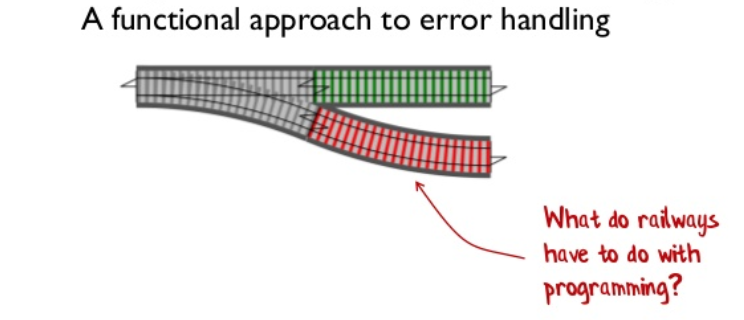

## TL;DR
**R.O.P.** Railway Oriented Programming is a technique to manage complex chains of transformations and checks focusing only on the "happy path" (<font color="green">**the good** = green rail</font>) and pretending that the errors (<font color="red">**the bad** = red rail</font>) does not happens.
Using it is very simple: you need only to "wrap" your return types into a **Result** and returning **good** or **bad** things.
<br><br>
IE: a simple function
```swift
func check(_ x: Int) -> Result<Int> {
    if x>10 {
        return good(x)
    } else {
        return bad("X should be greater than 10")
    }
}
```
**IE: a sequence of functions with a mix of normal and ROP functions...**
```swift
let complexComputation = good(22)
                        .then(check)
                        .then{$0/11} // Note that this is a closure
                        .then{x in "The result is \(x)!"}
print(complexComputation)
```
> Ok("The result is 2!")

**If something goes bad computation does not go wrong and we've a meaningful error...**
```swift
let miserableMistake = good(7)
                       .then(check) // check function act as a railway exchange
                       .then{$0/11} // Note that this is a closure
                       .then{x in "The result is \(x)!"}
print(miserableMistake)
```
> Error(__lldb_expr_21.SimpleError(msg: "X should be greater than 10"))

<font size="5"><center>...A railway to escape from the **pyramid of doom**!!</center></font>

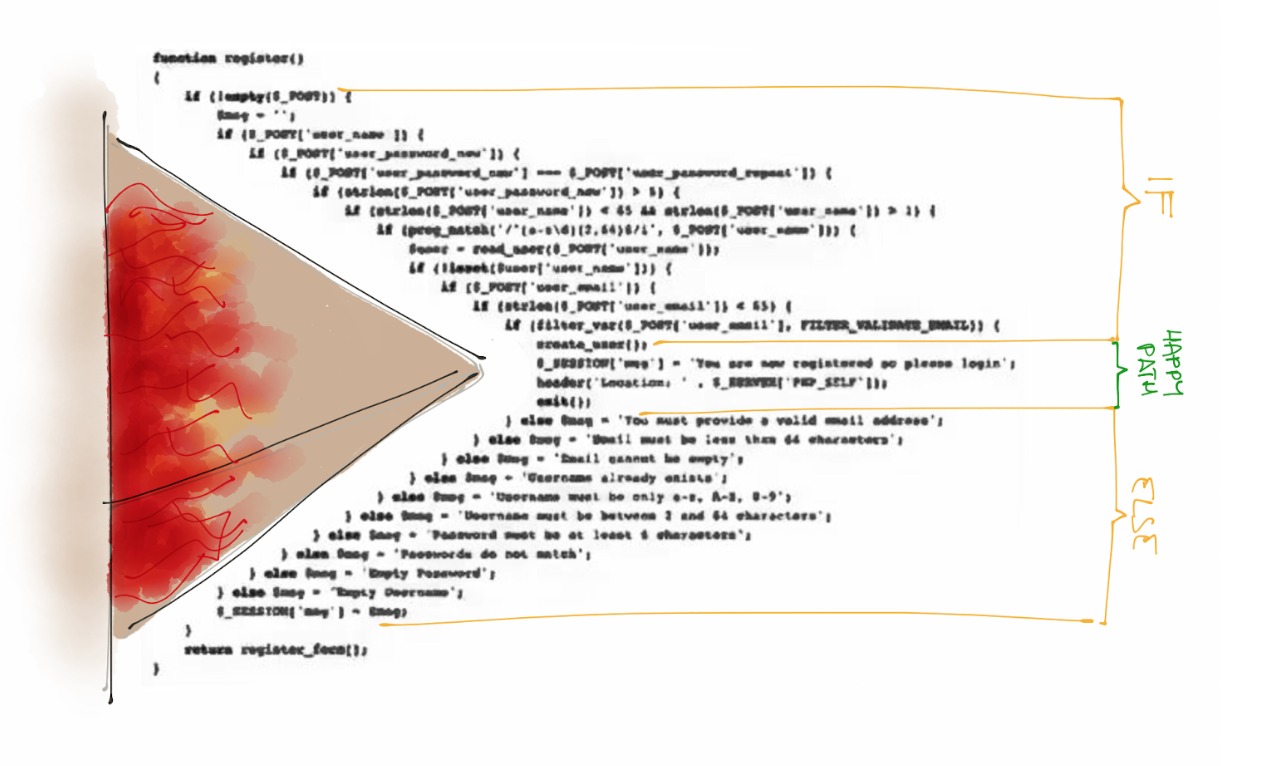

https://en.wikipedia.org/wiki/Pyramid_of_doom_(programming)

## Protocols and Types

The first protocol we intruduce is **DescriptiveError**. This protocol ensure that an error has an uderstandable message.

In [1]:
//Export
protocol DescriptiveError {
    func errorMessage()->String
}

**Result** is the hearth of ROP. This type is the 

In [2]:
//Export
struct SimpleError: DescriptiveError {
    let msg: String // Immutable
    init(_ msg: String) { self.msg = msg }
    func errorMessage() -> String { return msg }
}

In [3]:
//Export
enum Result<OK> {
    case Ok(OK)
    case Error(DescriptiveError) // We always want an error that follows this protocol
    
    // Methods and Properties
    var value: OK? {
        get {
            switch self {
                case .Ok(let value): return value
                case .Error(_): return nil // Don't need the value
            }
        }
    }    
    var error: String? {
        get {
            switch self {
                case .Ok(_): return nil
                case .Error(let err): return err.errorMessage()
            }
        }
    }
    //MAP: spark of magic..
    func then<OUT>(_ f: (OK)->OUT ) -> Result<OUT> {
        switch self {
            case .Ok(let val): return Result<OUT>.Ok(f(val))
            case .Error(let err): return Result<OUT>.Error(err) // Forward error
        }
    }
    //FLAT MAT: the real magic of monad! 
    func then<OUT>(_ f: (OK)->Result<OUT> ) -> Result<OUT> {
        switch self {
            case .Ok(let val): return f(val)
            case .Error(let err): return Result<OUT>.Error(err) // Forward error
        }
    }
    //Convenience
    func isOk() -> Bool {
        switch self {
            case .Ok: return true
            case .Error: return false
        }
    }
}

In [4]:
//Export 
//Convenience factory functions as static to quick find them with auto completition...
func good<T>(_ value: T) -> Result<T> {
    return Result<T>.Ok(value)
}
func bad<T>(_ msg: String) -> Result<T> {
    return Result<T>.Error(SimpleError(msg))
}
//Forwards errors adapting type to destination...
func bad<T,P>(_ parent: Result<P>) -> Result<T> {
    switch parent {
        case .Ok: return bad("WARNING: parent was not bad!") // good goes bad!! Warning!!
        case .Error(let val): return Result<T>.Error(val) // bad remains bad...
    }
}

## Basic types sample usage

### Deep dive into errors...

In [5]:
let omgAnError = SimpleError("Oh my god, somehting bad happens here!")
print(omgAnError.errorMessage())

Oh my god, somehting bad happens here!


In [6]:
struct ErrorWithInsight: DescriptiveError {
    let msg: String // Immutable
    let insight: Int
    init(_ msg: String, insight: Int) { 
        self.msg = msg 
        self.insight = insight
    }
    func errorMessage() -> String { return msg + " [insight = \(insight)]" }
}

let meaningfullerror = ErrorWithInsight("That's interesting error..", insight: 123)
print(meaningfullerror.errorMessage())

That's interesting error.. [insight = 123]


### The magic of ROP

Let's start with the basics

In [7]:
typealias IntResult = Result<Int> // You can alias the type to be more expressive ;-)

In [8]:
let goodResult = IntResult.Ok(33) // this is a good result!
print("The result is optional because you can't trust the computer... '\(goodResult.value)' Maybe ;-)")
print("That's a real value \(goodResult.value!)!")
print("Is the result good? Answer: \(goodResult.isOk())!")

The result is optional because you can't trust the computer... 'Optional(33)' Maybe ;-)
That's a real value 33!
Is the result good? Answer: true!


In [9]:
let mistake = IntResult.Error(SimpleError("That's a mistake..."))
print(mistake)
print(mistake.error!)

Error(__lldb_expr_21.SimpleError(msg: "That\'s a mistake..."))
That's a mistake...


In [10]:
func findMaxPrime(_ maxPrimeNumber: Int) -> IntResult {
    // We need some guard here preventing someone to ask for negative 
    switch maxPrimeNumber {
        case 0: return bad("Are you sure you're looking for a prime less or equals than Zero?")
        case 1: return IntResult.Ok(1) 
        case 2...3: return good(3) // good is a synonym of Ok ;-) 
        case 4...5: return good(5) // It's insane that type inference figure out the correct type here!!
        case 6...7: return good(7) 
        default:
            return bad("You're asking for to much computation... Can't find the biggest prime minus equals \(maxPrimeNumber)!")
    }
}

In [11]:
print("> This should be good...")
print(findMaxPrime(3))
print(findMaxPrime(7))

> This should be good...
Ok(3)
Ok(7)


In [12]:
print("> Let's do some mistakes")
print(findMaxPrime(0))
print(findMaxPrime(200))
print("> If you want to take a look at your error you can take a lok at '.error' property...")
print(findMaxPrime(0).error!) // Pretty sure that's an error

> Let's do some mistakes
Error(__lldb_expr_21.SimpleError(msg: "Are you sure you\'re looking for a prime less or equals than Zero?"))
Error(__lldb_expr_21.SimpleError(msg: "You\'re asking for to much computation... Can\'t find the biggest prime minus equals 200!"))
> If you want to take a look at your error you can take a lok at '.error' property...
Are you sure you're looking for a prime less or equals than Zero?


Let's go some more compleicated stuffs, but **WITHOUT MAGIC**

In [13]:
func mpyByValue(_ x: IntResult, mpy: Int) -> IntResult {
    switch x {
        case .Ok(let val): return IntResult.Ok(val*mpy)
        case .Error(_): return x // It's an error!
    }
}

In [14]:
print("Should be OK... >>", mpyByValue(findMaxPrime(5), mpy: 3))
print("Sure it fails... >>", mpyByValue(findMaxPrime(99), mpy: 3).error!)

Should be OK... >> Ok(15)
Sure it fails... >> You're asking for to much computation... Can't find the biggest prime minus equals 99!


**TRY TO DO SOME MAGIC**....

In [15]:
func magicMpyByValue(_ x: Int, mpy: Int) -> Int {
    return x*mpy
}

print(magicMpyByValue(2, mpy: 3))

6


Do it!

In [16]:
print("Should be OK... >>", findMaxPrime(5).then{magicMpyByValue($0, mpy: 3)})
print("Sure it fails... >>", findMaxPrime(99).then{magicMpyByValue($0, mpy: 3)}.error!)

Should be OK... >> Ok(15)
Sure it fails... >> You're asking for to much computation... Can't find the biggest prime minus equals 99!


**DO THE REAL MAGIC**....

In [17]:
func magicMpyByValueThatExplodes(_ x: Int, mpy: Int) -> IntResult {
    if (mpy<10) {
        return good(x*mpy)
    } else {
        return bad("Booooom!!!") // Int type is infered from result...
    }
}

print(magicMpyByValueThatExplodes(2, mpy: 3))
print(magicMpyByValueThatExplodes(2, mpy: 23))

Ok(6)
Error(__lldb_expr_21.SimpleError(msg: "Booooom!!!"))


In [18]:
func magicMpyByValueThatExplodesWithNoTypeAlias(_ x: Int, mpy: Int) -> Result<Int> {
    if (mpy<10) {
        return good(x*mpy)
    } else {
        return bad("Booooom!!!") // Int type is infered from result...
    }
}

print(magicMpyByValueThatExplodesWithNoTypeAlias(2, mpy: 3))
print(magicMpyByValueThatExplodesWithNoTypeAlias(2, mpy: 23))

Ok(6)
Error(__lldb_expr_21.SimpleError(msg: "Booooom!!!"))


In [19]:
print("> Should be OK... >>", findMaxPrime(5).then{magicMpyByValueThatExplodes($0, mpy: 3)})
print("Wow we survive to function application")

print("> Sure it fails... >>", findMaxPrime(99).then{magicMpyByValueThatExplodes($0, mpy: 3)}.error!)
print("It breaks at the beginning...")

print("> Maybe it fails?! >>", findMaxPrime(3).then{magicMpyByValueThatExplodes($0, mpy: 33)}.error!)
print("OMG: it explodes!!!")

> Should be OK... >> Ok(15)
Wow we survive to function application
> Sure it fails... >> You're asking for to much computation... Can't find the biggest prime minus equals 99!
It breaks at the beginning...
> Maybe it fails?! >> Booooom!!!
OMG: it explodes!!!


Let's check that the **bad forwarding** works properly

In [20]:
let badInt = magicMpyByValueThatExplodesWithNoTypeAlias(2, mpy: 23)
print(badInt)
let badString: Result<String> = bad(badInt)
print(badString)
let goodInt = magicMpyByValueThatExplodesWithNoTypeAlias(2, mpy: 3)
print(goodInt)
let goodIntGoesBadString: Result<String> = bad(goodInt)
print(goodIntGoesBadString, "...Probably we shoult raise an exception here...")

Error(__lldb_expr_21.SimpleError(msg: "Booooom!!!"))
Error(__lldb_expr_21.SimpleError(msg: "Booooom!!!"))
Ok(6)
Error(__lldb_expr_21.SimpleError(msg: "WARNING: parent was not bad!")) ...Probably we shoult raise an exception here...


**VERY INCEDIBLE MAGIC!!!**

In [21]:
func veryIncredibleMagic(_ x: Int, mpy: Int) -> Result<String> {
    if (mpy<10) {
        return good("Great job you made it! The result is \(x*mpy)")  // WOW Swift infers <String> type!!
    } else {
        return bad("Booooom!!!")
    }
}

print(magicMpyByValueThatExplodes(2, mpy: 3))
print(magicMpyByValueThatExplodes(2, mpy: 23))

Ok(6)
Error(__lldb_expr_21.SimpleError(msg: "Booooom!!!"))


In [22]:
print("> Should be OK... >>", findMaxPrime(5).then{veryIncredibleMagic($0, mpy: 3)}.value!)
print("Wow we survive to function application")

print("> Sure it fails... >>", findMaxPrime(99).then{veryIncredibleMagic($0, mpy: 3)}.error!)
print("It breaks at the beginning...")

print("> Maybe it fails?! >>", findMaxPrime(3).then{veryIncredibleMagic($0, mpy: 33)}.error!)
print("OMG: it explodes!!!")

> Should be OK... >> Great job you made it! The result is 15
Wow we survive to function application
> Sure it fails... >> You're asking for to much computation... Can't find the biggest prime minus equals 99!
It breaks at the beginning...
> Maybe it fails?! >> Booooom!!!
OMG: it explodes!!!


In [23]:
func screamIt(_ str: String) -> String { return str.uppercased() } // Note that we're working with string!!!
print(screamIt("say it louder"))

SAY IT LOUDER


**TELL EVERYBODY ABOUT THAT!!!**

In [24]:
print("> The infinite chain of rules!")
print(findMaxPrime(5)
      .then{veryIncredibleMagic($0, mpy: 3)}
      .then{screamIt($0)}
      .then{$0 + "!!"} // Closure on the fly...
     )

print("> That stops the calculation at first error")
print(findMaxPrime(9)
      .then{veryIncredibleMagic($0, mpy: 3)}
      .then{screamIt($0)}
     )

print("> Can't scream your success if there is an error!")
print(findMaxPrime(3)
      .then{veryIncredibleMagic($0, mpy: 75)}
      .then{screamIt($0)}
     )

> The infinite chain of rules!
Ok("GREAT JOB YOU MADE IT! THE RESULT IS 15!!")
> That stops the calculation at first error
Error(__lldb_expr_21.SimpleError(msg: "You\'re asking for to much computation... Can\'t find the biggest prime minus equals 9!"))
> Can't scream your success if there is an error!
Error(__lldb_expr_21.SimpleError(msg: "Booooom!!!"))


## APPENDIX A: TL;DR example

In [25]:
func check(_ x: Int) -> Result<Int> {
    if x>10 {
        return good(x)
    } else {
        return bad("X should be greater than 10")
    }
}

print(check(20))
print(check(10))

Ok(20)
Error(__lldb_expr_21.SimpleError(msg: "X should be greater than 10"))


In [26]:
let complexComputation = good(22)
                            .then(check)
                            .then{$0/11} // Note that this is a closure
                            .then{x in "The result is \(x)!"}
print(complexComputation)

Ok("The result is 2!")


In [27]:
let miserableMistake = good(7)
                            .then(check) // check function act as a railway exchange
                            .then{$0/11} // Note that this is a closure
                            .then{x in "The result is \(x)!"}
print(miserableMistake)

Error(__lldb_expr_21.SimpleError(msg: "X should be greater than 10"))


## APPENDIX B: Real R.O.P. with type aware errors...
The above implementation is a Fast® implementation, that act more as a "error description" aware Result than a type aware one.<br>
The classical implementation of ROP (*aka Either with new name and swapped args*) is: 
<br><br>
```swift
enum Result<OK,ERR> {
    case Ok(OK)
    case Error(ERR)
// More here...
}
```
<br><br>
Anyway this implementation is very simple and intuitive to use thanks to the **good and bad** convenience functions and **incredible swit type inference**.